In [1]:
#import image_analysis as ia
import NearestNeighbor as NN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Image Analysis
Image analysis involves 2 main steps: Segmentation and Object detection
## 1.1 Segmentation
First the images are segemented into individual cells and their boundaries are stored as ImageJ ROIs in zip files. These can be opened later in FIJI/ImageJ vor viewing and analysis.
Segmentation involves the following steps:
1. Thresholding: Images are thresholded by the multiotsu thresholding technique, which produces 2 numbers. The lower number is chosen as a threshold.
2. Cell separation: During thresholding cells may be too close together which would merge them together. To solve this problem Cell centers are identified and starting from the cell centers watershed segmentation is performed. This seperates the thrsholded area into individual labeled regions that represent the cells. Cell centers are identified via either of the following methods:
    - By nuclei: If nuclei were imaged by a DAPI stain, they are identified as cell centers.
    - By distance transform: If no nuclei were captured a distance transform is performed. Resulting peaks are taken as cell centers.
3. Cell identification and measurement: From each cell measurements are taken involving the area, mean and median intensities. Furthermore the boundaries are converted to ROIs and stored in a corresponding zip file.

In [2]:
data = "D:\Raphael\Data"
exID = 3
CD={0:"aSyn-GFP",1:"aSyn-AB",2:"LAMP1/LC3"}
#seg = ia.segmentation(data=data,exID=exID,p_max=500,t_mod=1,ch_dic=CD)
#seg.plot_segmentation(IDs=[7,32,77])
    

In [3]:
#seg.segment_all()

In [4]:
#detect=ia.detection(data=data,exID=exID,ch_dic=CD)
#detect.plot_detection(channel="aSyn-GFP")

In [5]:
#detect.detect_all()

In [6]:
nn = NN.NN(data=data,YChannel="aSyn-GFP")

In [7]:
#dic = nn.calculate()

In [8]:
#nn.load()

In [9]:
nn.calculate_e()

In [10]:
df = nn.df

In [11]:
df.head()

,label,bbox-0,bbox-1,bbox-2,bbox-3,label_GFP,bbox-0_GFP,bbox-1_GFP,bbox-2_GFP,bbox-3_GFP,...,CID.3,CID.4,CID.5,CID,Nx,Ny,Ct,st,Cq,e
0,3,685,797,1413,1464,3,685,797,1413,1464,...,2,2,2,2,1590,36,0.138889,11,0.002291,4.251779
1,1,504,721,1597,1402,1,504,721,1597,1402,...,3,3,3,3,615,145,0.082759,11,0.003522,3.239677
2,5,269,703,789,1193,5,269,703,789,1193,...,8,8,8,8,165,99,0.000000,11,0.002277,-12.338036
3,6,589,716,1683,1388,6,589,716,1683,1388,...,9,9,9,9,667,128,0.070312,11,0.002733,3.317821
4,3,628,1073,1351,1678,3,628,1073,1351,1678,...,12,12,12,12,303,73,0.561644,10,0.433283,0.516305


In [12]:
df = df[df["Group2"]=="LC3"]

In [13]:
df["NyA"] = np.round(df["Ny"]*df["Ct"])
df2 = df[df["Replicate"]==2].groupby(["Group1"]).sum()
df2.head()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_2576\2352027820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NyA"] = np.round(df["Ny"]*df["Ct"])


,label,bbox-0,bbox-1,bbox-2,bbox-3,label_GFP,bbox-0_GFP,bbox-1_GFP,bbox-2_GFP,bbox-3_GFP,...,CID.4,CID.5,CID,Nx,Ny,Ct,st,Cq,e,NyA
Group1,,,,,,,,,,,,,,,,,,,,,
FY,979,25944,18193,44283,38920,979,25944,18193,44283,38920,...,126124,126124,126124,652147,661808,19.196153,341,14.705778,20.520790,427764.0
TP,763,15876,16365,32209,31493,763,15876,16365,32209,31493,...,125088,125088,125088,554176,568612,14.596677,242,11.252940,14.313058,369588.0
X,3571,35961,29127,62768,57096,3571,35961,29127,62768,57096,...,310945,310945,310945,1123247,1283795,29.509028,462,20.822791,38.210152,889710.0


In [14]:
def Ct(df):
    return df["NyA"]/df["Ny"]

def Cq(df,stsize = 11):
    return df["Autophagosome_area"]/df["area_GFP"]/stsize

def e(Ct,Co):
        #print(Ct)
        Ct = Ct.replace(to_replace = 0, value = 0.00000001)
        Co = Co.replace(to_replace = 0, value = 0.00000001)
        Ct = Ct.replace(to_replace = 1, value = 0.9999999)
        Co = Co.replace(to_replace = 1, value = 0.9999999)
        return np.log(Ct/(1-Ct))-np.log(Co/(1-Co))
    
df2["Ct"] = Ct(df2)
df2["Cq"] = Cq(df2)
df2["e"] = e(df2["Ct"],df2["Cq"])
df2.head()

,label,bbox-0,bbox-1,bbox-2,bbox-3,label_GFP,bbox-0_GFP,bbox-1_GFP,bbox-2_GFP,bbox-3_GFP,...,CID.4,CID.5,CID,Nx,Ny,Ct,st,Cq,e,NyA
Group1,,,,,,,,,,,,,,,,,,,,,
FY,979,25944,18193,44283,38920,979,25944,18193,44283,38920,...,126124,126124,126124,652147,661808,0.646357,341,0.482011,0.675052,427764.0
TP,763,15876,16365,32209,31493,763,15876,16365,32209,31493,...,125088,125088,125088,554176,568612,0.649983,242,0.500102,0.618555,369588.0
X,3571,35961,29127,62768,57096,3571,35961,29127,62768,57096,...,310945,310945,310945,1123247,1283795,0.693031,462,0.509012,0.778275,889710.0


In [15]:
from scipy.stats import binom

def p_val(e,N,CtX,CoX):
        E = np.exp(e+np.log(CoX/(1-CoX)))
        Ct = E/(1+E)
        p = 1-binom.cdf(Ct*N, N, CtX)
        return p

def p_val_ind(N,CtX,CoX):
        p = 1-binom.cdf(CtX*N, N, CoX)
        return p
    
df["p"] = p_val_ind(df["Ny"].values,df["Ct"].values,df["Cq"].values)
df.head()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_2576\3782211859.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["p"] = p_val_ind(df["Ny"].values,df["Ct"].values,df["Cq"].values)


,label,bbox-0,bbox-1,bbox-2,bbox-3,label_GFP,bbox-0_GFP,bbox-1_GFP,bbox-2_GFP,bbox-3_GFP,...,CID.5,CID,Nx,Ny,Ct,st,Cq,e,NyA,p
13,6,822,779,1571,1236,6,822,779,1571,1236,...,54,54,986,54,0.166667,11,0.011234,2.868115,9.0,4.879223e-10
14,9,690,888,1533,1726,9,690,888,1533,1726,...,63,63,321,44,0.590909,11,0.473530,0.473705,26.0,4.350124e-02
15,6,690,164,1382,788,6,690,164,1382,788,...,69,69,500,221,0.420814,11,0.372624,0.201547,93.0,6.129440e-02
16,7,813,1096,1433,1442,7,813,1096,1433,1442,...,70,70,3017,209,0.947368,11,0.434755,3.152850,198.0,0.000000e+00
17,8,871,783,1427,1100,8,871,783,1427,1100,...,71,71,221,64,0.187500,11,0.009953,3.133504,12.0,7.704948e-14


In [16]:
def e(Ct,Co):
        #print(Ct)
        Ct = Ct.replace(to_replace = 0, value = 0.00000001)
        Co = Co.replace(to_replace = 0, value = 0.00000001)
        Ct = Ct.replace(to_replace = 1, value = 0.9999999)
        Co = Co.replace(to_replace = 1, value = 0.9999999)
        return np.log(Ct/(1-Ct))-np.log(Co/(1-Co))

def crit_e(N,Ct,Co):
        CC = binom.ppf(0.95, N, Co)
        return e((CC/N),Co)
    
df["crit_e"] = crit_e(df["Ny"],df["Ct"],df["Cq"])
df.head()

C:\Users\Raphael\AppData\Local\Temp\ipykernel_2576\1211728196.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["crit_e"] = crit_e(df["Ny"],df["Ct"],df["Cq"])


,label,bbox-0,bbox-1,bbox-2,bbox-3,label_GFP,bbox-0_GFP,bbox-1_GFP,bbox-2_GFP,bbox-3_GFP,...,CID,Nx,Ny,Ct,st,Cq,e,NyA,p,crit_e
13,6,822,779,1571,1236,6,822,779,1571,1236,...,54,986,54,0.166667,11,0.011234,2.868115,9.0,4.879223e-10,1.219456
14,9,690,888,1533,1726,9,690,888,1533,1726,...,63,321,44,0.590909,11,0.473530,0.473705,26.0,4.350124e-02,0.473705
15,6,690,164,1382,788,6,690,164,1382,788,...,69,500,221,0.420814,11,0.372624,0.201547,93.0,6.129440e-02,0.220086
16,7,813,1096,1433,1442,7,813,1096,1433,1442,...,70,3017,209,0.947368,11,0.434755,3.152850,198.0,0.000000e+00,0.233768
17,8,871,783,1427,1100,8,871,783,1427,1100,...,71,221,64,0.187500,11,0.009953,3.133504,12.0,7.704948e-14,1.165854


In [17]:
import math
df["r"] = np.sqrt(df["Autophagosome_area"]/math.pi)/df["Nx"]
print(df["r"].mean())

C:\Users\Raphael\AppData\Local\Temp\ipykernel_2576\3059291859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["r"] = np.sqrt(df["Autophagosome_area"]/math.pi)/df["Nx"]


0.20980273133054156


In [18]:
df2["p"] = p_val_ind(df2["Ny"],df2["Ct"],df2["Cq"])
df2["crit_e"] = crit_e(df2["Ny"],df2["Ct"],df2["Cq"])
df2.head()

,label,bbox-0,bbox-1,bbox-2,bbox-3,label_GFP,bbox-0_GFP,bbox-1_GFP,bbox-2_GFP,bbox-3_GFP,...,CID,Nx,Ny,Ct,st,Cq,e,NyA,p,crit_e
Group1,,,,,,,,,,,,,,,,,,,,,
FY,979,25944,18193,44283,38920,979,25944,18193,44283,38920,...,126124,652147,661808,0.646357,341,0.482011,0.675052,427764.0,0.0,0.004046
TP,763,15876,16365,32209,31493,763,15876,16365,32209,31493,...,125088,554176,568612,0.649983,242,0.500102,0.618555,369588.0,0.0,0.004361
X,3571,35961,29127,62768,57096,3571,35961,29127,62768,57096,...,310945,1123247,1283795,0.693031,462,0.509012,0.778275,889710.0,0.0,0.002903


In [19]:
df[df["p"]<0.001].groupby(["Replicate","Group1"])["p"].count()/df.groupby(["Group2","Group1"])["p"].count()

Group1  Replicate  Group2
FY      1          LC3       0.222222
        2          LC3       0.666667
TP      1          LC3       0.390244
        2          LC3       0.512195
X       2          LC3       1.000000
Name: p, dtype: float64

In [20]:
import seaborn as sns


<AxesSubplot:xlabel='Group1', ylabel='e'>

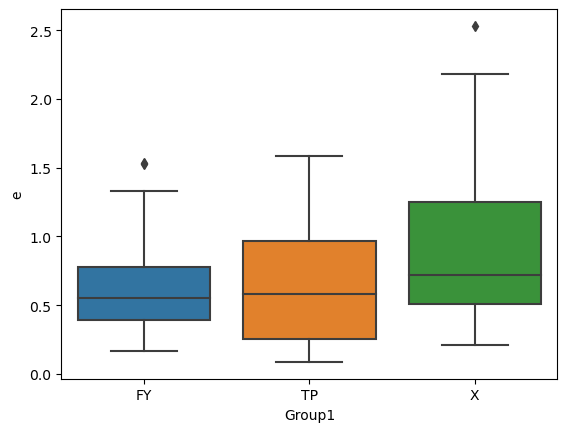

In [21]:
sns.boxplot(data=df[df["Replicate"]==2].dropna(), x="Group1",y="e")

<AxesSubplot:xlabel='Group1', ylabel='Nx'>

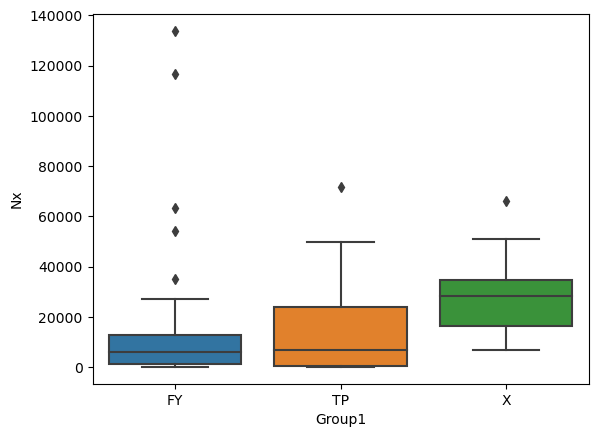

In [22]:
sns.boxplot(data=df, x="Group1",y="Nx")

C:\Users\Raphael\AppData\Local\Temp\ipykernel_2576\4228529905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ediff"] = df["e"]-df["crit_e"]


<AxesSubplot:xlabel='Group1', ylabel='ediff'>

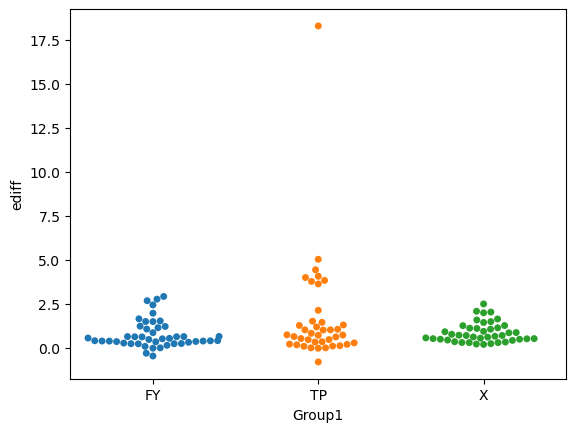

In [23]:
df["ediff"] = df["e"]-df["crit_e"]
sns.swarmplot(data=df[df["Group2"]=="LC3"].dropna(), x="Group1",y="ediff")

In [24]:
import scipy.stats as stats
df = df[df["Group2"]=="LC3"].dropna()
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df[df["Group1"]=="X"]['e'], df[df["Group1"]=="TP"]['e'], df[df["Group1"]=="FY"]['e'])
print(fvalue, pvalue)

1.0886872137587706 0.3398539650652847


In [25]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df['e'].dropna(), groups=df['Group1'], alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FY,TP,0.4645,0.4621,-0.4625,1.3915,False
FY,X,-0.0779,0.9778,-0.9931,0.8373,False
TP,X,-0.5424,0.3622,-1.4849,0.4,False


In [26]:
print(df["Ct"].values)
print(df["Cq"].values)
print(df["e"].values)

[0.16666667 0.59090909 0.42081448 0.94736842 0.1875     0.25927234
 0.34146341 0.28340081 0.1875     0.33333333 0.3902439  0.13793103
 0.70938628 0.32024978 0.69565217 0.21868583 0.         0.51145038
 0.27272727 0.56657224 0.05882353 0.04545455 0.53103448 0.27727273
 0.62719298 0.35572572 0.83333333 0.99104478 0.625      0.31879195
 0.36452242 0.46428571 0.72763007 0.44668188 0.46948664 0.62221195
 0.68870719 0.65129401 0.69685265 0.77779214 0.69093259 0.64152542
 0.69886364 0.52415679 0.16622748 0.21875    0.4797701  0.61955794
 0.36734015 0.60653915 0.61034483 0.73334781 0.70963756 0.76246891
 0.7577271  0.5904936  0.72184376 0.59580805 0.76402052 0.60675011
 0.67068786 0.74536977 0.83333333 0.75780043 0.65245488 0.60023447
 0.5089365  0.58423949 0.58978442 0.57846556 0.66945344 0.70770677
 0.72147937 0.68248996 0.59942467 0.71903506 0.66913664 0.62131691
 0.72249322 0.63031743 0.66074741 0.76251055 0.67019714 0.71460177
 0.77385057 0.68810542 0.72621121 0.77767808 0.63341291 0.7099